In [ ]:
!file /content/drive/MyDrive/Dataset/Dataset/cap.v1i.multiclass.zip

/content/drive/MyDrive/Dataset/Dataset/cap.v1i.multiclass.zip: Zip archive data, at least v2.0 to extract, compression method=deflate


In [ ]:
!ls -R


.:
 best_skin_model.keras
 drive
 sample_data
 test_results_binary.csv
 test_results_raw.csv
'WhatsApp Image 2024-11-10 at 18.37.19_5a60a73a.jpg'
'WhatsApp Image 2024-11-10 at 18.37.19_c0c9c375.jpg'
'WhatsApp Image 2025-11-29 at 13.50.15_555392bc (1).jpg'
'WhatsApp Image 2025-11-29 at 13.50.15_555392bc (2).jpg'
'WhatsApp Image 2025-11-29 at 13.50.15_555392bc (3).jpg'
'WhatsApp Image 2025-11-29 at 13.50.15_555392bc.jpg'
'WhatsApp Image 2025-11-29 at 13.59.39_d59211c0.jpg'
'WhatsApp Image 2025-11-29 at 14.01.09_38de0e77 (1).jpg'
'WhatsApp Image 2025-11-29 at 14.01.09_38de0e77 (2).jpg'
'WhatsApp Image 2025-11-29 at 14.01.09_38de0e77.jpg'
'WhatsApp Image 2025-11-29 at 14.02.54_0a8c485d (1).jpg'
'WhatsApp Image 2025-11-29 at 14.02.54_0a8c485d (2).jpg'
'WhatsApp Image 2025-11-29 at 14.02.54_0a8c485d.jpg'
'WhatsApp Image 2025-11-29 at 14.04.21_daec514b.jpg'
'WhatsApp Image 2025-11-29 at 14.05.48_f5fff1b4 (1).jpg'
'WhatsApp Image 2025-11-29 at 14.05.48_f5fff1b4.jpg'
'WhatsApp Image 2025-11-29 

In [ ]:
!unzip -q /content/drive/MyDrive/Dataset/Dataset/cap.v1i.multiclass.zip -d /content/drive/MyDrive/Dataset/Dataset/cap.v1

replace /content/drive/MyDrive/Dataset/Dataset/cap.v1/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# ==========================================
# MASTER SKIN DISEASE MODEL SCRIPT
# ==========================================

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ==========================================
# 1. CONFIGURATION (UPDATED FOR YOUR STRUCTURE)
# ==========================================

# Make sure all these start with '/content/drive'
TRAIN_DIR = '/content/drive/MyDrive/Dataset/Dataset/cap.v1/train'
TRAIN_CSV = '/content/drive/MyDrive/Dataset/Dataset/cap.v1/train/_classes.csv'

VALID_DIR = '/content/drive/MyDrive/Dataset/Dataset/cap.v1/valid'
VALID_CSV = '/content/drive/MyDrive/Dataset/Dataset/cap.v1/valid/_classes.csv'

TEST_DIR  = '/content/drive/MyDrive/Dataset/Dataset/cap.v1/test'
TEST_CSV  = '/content/drive/MyDrive/Dataset/Dataset/cap.v1/test/_classes.csv'

# Settings
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

# ------------------------------------------
# 2. AUTOMATIC DATA CLEANING FUNCTION
# ------------------------------------------
def load_and_clean_data(csv_path, image_dir):
    print(f"\n--- Processing: {image_dir} ---")

    # 1. Check if directory exists (Debugging step)
    if not os.path.exists(image_dir):
        print(f"ERROR: The folder path is WRONG. Python cannot find:\n{image_dir}")
        return None, None

    # 2. Load the specific CSV for this folder
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"ERROR: Could not find CSV file at:\n{csv_path}")
        return None, None

    # 3. Fix Filenames (Add .jpg if missing)
    df['filename'] = df['filename'].astype(str)
    # Peek at actual files to check extension
    try:
        files_on_disk = os.listdir(image_dir)
        if len(files_on_disk) > 0:
            sample_file = files_on_disk[0]
            # If CSV has 'image1' but disk has 'image1.jpg', add extension
            if sample_file.endswith('.jpg') and not df['filename'].iloc[0].endswith('.jpg'):
                df['filename'] = df['filename'].apply(lambda x: x + ".jpg")

            # 4. Filter: Only keep rows where image actually exists
            files_set = set(files_on_disk)
            df_clean = df[df['filename'].isin(files_set)].copy()
        else:
            print("WARNING: Folder is empty!")
            return None, None
    except Exception as e:
        print(f"Error reading folder: {e}")
        return None, None

    # 5. Merge Duplicates (Clean Up)
    # Merge 'Dark Circle' variants
    if 'Dark Circle' in df_clean.columns and 'Dark circle' in df_clean.columns:
        df_clean['Dark Circle'] = df_clean[['Dark Circle', 'Dark circle']].max(axis=1)
        df_clean.drop(columns=['Dark circle'], inplace=True)

    # Merge 'dark spot' variants
    if 'dark spot' in df_clean.columns and 'darkspot' in df_clean.columns:
        df_clean['dark spot'] = df_clean[['dark spot', 'darkspot']].max(axis=1)
        df_clean.drop(columns=['darkspot'], inplace=True)

    # Remove garbage columns
    if '3' in df_clean.columns:
        df_clean.drop(columns=['3'], inplace=True)

    # 6. Get Disease Columns
    disease_columns = [c for c in df_clean.columns if c not in ['filename', 'filename.1']]

    print(f"Images Found: {len(df_clean)}")
    return df_clean, disease_columns

# ------------------------------------------
# 3. EXECUTE LOADING
# ------------------------------------------
train_df, train_cols = load_and_clean_data(TRAIN_CSV, TRAIN_DIR)
valid_df, valid_cols = load_and_clean_data(VALID_CSV, VALID_DIR)

# STOP HERE IF ERROR OCCURRED
if train_df is None or valid_df is None:
    raise ValueError("Stopping script because files were not found. Check paths above.")

# Ensure columns match
FINAL_COLS = train_cols
# Align validation columns to training columns
for c in FINAL_COLS:
    if c not in valid_df.columns:
        valid_df[c] = 0
valid_df = valid_df[['filename'] + FINAL_COLS]

print(f"\nFinal Disease List ({len(FINAL_COLS)}): {FINAL_COLS}")

# ------------------------------------------
# 3. LOAD DATA
# ------------------------------------------
# If you have separate CSVs for train/valid, change CSV_PATH below to specific paths



--- Processing: /content/drive/MyDrive/Dataset/Dataset/cap.v1/train ---
Images Found: 627

--- Processing: /content/drive/MyDrive/Dataset/Dataset/cap.v1/valid ---
Images Found: 178

Final Disease List (16): ['Dark Circle', 'Eyebag', 'acne scar', 'blackhead', 'blackheads', 'dark spot', 'freckle', 'melasma', 'nodules', 'papules', 'pustules', 'skinredness', 'vascular', 'whitehead', 'whiteheads', 'wrinkle']


In [ ]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,  <-- I REMOVED THIS LINE
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,  # Added slightly more movement to help learning
    height_shift_range=0.1,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    # rescale=1./255   <-- I REMOVED THIS LINE TOO
)

print("Generators updated: Scaling fixed for EfficientNet.")

Generators updated: Scaling fixed for EfficientNet.


In [ ]:
# ------------------------------------------
# 4. GENERATORS & MODEL
# ------------------------------------------


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col=FINAL_COLS,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=VALID_DIR,
    x_col="filename",
    y_col=FINAL_COLS,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

def build_model(num_classes):
    # Load model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # UNFREEZE the top 20 layers so it can learn specifically about skin
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    # Use a LOWER learning rate because we unfreezed layers
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])

    return model

Found 627 validated image filenames.
Found 178 validated image filenames.


In [ ]:
# ------------------------------------------
# 5. TRAIN
# ------------------------------------------
checkpoint = ModelCheckpoint('best_skin_model.keras', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.3876 - auc: 0.7151 - loss: 0.2458 - val_accuracy: 0.5112 - val_auc: 0.7339 - val_loss: 0.1557
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.4335 - auc: 0.7709 - loss: 0.2075 - val_accuracy: 0.5000 - val_auc: 0.7318 - val_loss: 0.1616
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.4435 - auc: 0.8010 - loss: 0.1975 - val_accuracy: 0.4888 - val_auc: 0.7261 - val_loss: 0.1659
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.4795 - auc: 0.7814 - loss: 0.1666 - val_accuracy: 0.5000 - val_auc: 0.7230 - val_loss: 0.1684
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.4437 - auc: 0.8052 - loss: 0.1705 - val_accuracy: 0.4944 - val_auc: 0.7201 - val_loss: 0.1698
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.5009 - auc: 0.8184 - loss: 0.1587 - val_accuracy: 0.4944 - val_auc: 0.7160 - val_loss: 0.1703


In [ ]:
# ==========================================
# PHASE 2: FINE-TUNING
# ==========================================

print("Loading best weights from Phase 1...")
model.load_weights('best_skin_model.keras')

# 1. Unfreeze the base model
model.layers[0].trainable = True

# 2. Freeze the bottom layers (Keep generic shapes), Unfreeze top layers (Specific textures)
# EfficientNetB0 has about 237 layers. We unfreeze the last 50.
for layer in model.layers[0].layers[:-50]:
    layer.trainable = False

print("Top 50 layers unfrozen for fine-tuning.")

# 3. Re-compile with a VERY LOW learning rate
# We use 1e-5 (0.00001) to make tiny adjustments without destroying previous learning
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True, name='auc')])

# 4. Train again (Phase 2)
print("Starting Fine-Tuning...")
history_fine = model.fit(
    train_generator,
    epochs=15,  # Run for 15 more epochs
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stop]
)

Loading best weights from Phase 1...
Top 50 layers unfrozen for fine-tuning.
Starting Fine-Tuning...
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.4562 - auc: 0.7372 - loss: 0.1863 - val_accuracy: 0.5000 - val_auc: 0.7317 - val_loss: 0.1611
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.4649 - auc: 0.8372 - loss: 0.1899 - val_accuracy: 0.4888 - val_auc: 0.7300 - val_loss: 0.1657
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.4633 - auc: 0.7515 - loss: 0.1766 - val_accuracy: 0.5000 - val_auc: 0.7241 - val_loss: 0.1680
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.4561 - auc: 0.8227 - loss: 0.1688 - val_accuracy: 0.5000 - val_auc: 0.7201 - val_loss: 0.1692
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.4929 - auc: 0.7969 - loss: 0.1703 - val_accuracy: 0.4944 - val_auc: 0.7167 - val_loss: 0.1694
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.4667 - auc: 0.8229 - loss: 0.1658 - val_ac

In [ ]:
# ==========================================
# FINAL STEP: PREDICT ON NEW IMAGES
# ==========================================
import cv2
from google.colab import files
from IPython.display import Image, display

# 1. Load the BEST saved model (ignoring the overfitting at the end)
print("Loading the best model...")
model.load_weights('best_skin_model.keras')

def predict_skin_disease(image_path):
    # A. Preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image.")
        return

    # Convert BGR to RGB (OpenCV loads as BGR, but model trained on RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to 224x224
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

    # Expand dims to (1, 224, 224, 3)
    img_batch = np.expand_dims(img_resized, axis=0)

    # B. Predict
    # Note: We do NOT divide by 255 here because we removed rescaling from the generator!
    predictions = model.predict(img_batch)[0]

    # C. Display Results
    display(Image(image_path, width=200))
    print("\n--- DIAGNOSIS REPORT ---")

    # We lower the threshold to 30% (0.3) because medical models are often cautious
    found_issues = False
    for i, prob in enumerate(predictions):
        if prob > 0.30:
            found_issues = True
            confidence = prob * 100
            print(f"Detected: {FINAL_COLS[i]} ({confidence:.1f}% confidence)")

    if not found_issues:
        print("Skin appears healthy (No conditions detected above 30% confidence).")

# 2. Upload and Test
print("Upload a face image to test:")
uploaded = files.upload()

for filename in uploaded.keys():
    predict_skin_disease(filename)

In [ ]:
import shutil
import os

# Define the destination in your Google Drive
# We will create a 'SkinModel' folder to keep it safe
destination_folder = '/content/drive/MyDrive/SkinModel_Final'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy the file
source = 'best_skin_model.keras'
destination = os.path.join(destination_folder, 'best_skin_model.keras')

try:
    shutil.copy(source, destination)
    print(f"✅ SUCCESS: Model saved securely at: {destination}")
    print("You can now close Colab safely.")
except FileNotFoundError:
    print("❌ ERROR: Could not find 'best_skin_model.keras'. Did you run the training block?")

In [ ]:
# ==========================================
# STEP 7: RUN ON TEST DATA
# ==========================================
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

print("--- Loading Test Data ---")

# 1. Load and Clean Test Data (Using the function we made earlier)
test_df, test_cols = load_and_clean_data(TEST_CSV, TEST_DIR)

if test_df is None or len(test_df) == 0:
    print("❌ ERROR: No images found in Test folder. Check path variables!")
else:
    # 2. Align Columns (Crucial!)
    # The test CSV might miss some diseases that were in Train, or have extras.
    # We force it to look EXACTLY like the training data.
    for c in FINAL_COLS:
        if c not in test_df.columns:
            test_df[c] = 0 # Add missing disease columns with 0

    # Keep only the columns the model knows, in the exact order
    test_df = test_df[['filename'] + FINAL_COLS]

    print(f"Test Data Ready: {len(test_df)} images.")

    # 3. Create Test Generator
    # IMPORTANT: shuffle=False so we can match predictions to filenames later
    test_datagen = ImageDataGenerator() # No rescale, just like training

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_DIR,
        x_col="filename",
        y_col=FINAL_COLS,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        shuffle=False
    )

    # 4. Evaluate (The Overall Score)
    print("\n--- Calculating Metrics ---")
    results = model.evaluate(test_generator)
    print(f"\n✅ Final Test Accuracy: {results[1]*100:.2f}%")
    print(f"✅ Final Test AUC:      {results[2]:.4f}")

    # 5. Generate Predictions for every image
    print("\n--- Generating Prediction CSV ---")
    predictions = model.predict(test_generator)

    # Create a DataFrame with the results
    results_df = pd.DataFrame(predictions, columns=FINAL_COLS)
    results_df.insert(0, "filename", test_generator.filenames)

    # Save raw probabilities
    results_df.to_csv('test_results_raw.csv', index=False)

    # Create a "Readable" version (Applying 30% Threshold)
    readable_results = results_df.copy()
    for col in FINAL_COLS:
        # Convert probability 0.8 -> 1 (True), 0.1 -> 0 (False)
        readable_results[col] = readable_results[col].apply(lambda x: 1 if x > 0.3 else 0)

    readable_results.to_csv('test_results_binary.csv', index=False)
    print("✅ Saved 'test_results_binary.csv'. Check your files panel!")

    # 6. Show a snapshot of performance
    # Let's see how well it found 'pimples' (or the first disease in your list)
    first_disease = FINAL_COLS[0]
    true_labels = test_df[first_disease].values
    pred_labels = readable_results[first_disease].values

    print(f"\nQuick Check for '{first_disease}':")
    print(classification_report(true_labels, pred_labels, target_names=['No', 'Yes']))

In [ ]:
import pandas as pd

# 1. Define the Relationship: Disease -> Key Ingredient
ingredient_map = {
    # ACNE GROUP
    'pimples':   ['Salicylic Acid', 'Benzoyl Peroxide', 'Tea Tree'],
    'papules':   ['Niacinamide', 'Salicylic Acid', 'Zinc'],
    'pustules':  ['Benzoyl Peroxide', 'Centella'],
    'nodules':   ['Adapalene', 'Retinol'],
    'acne scar': ['Vitamin C', 'Alpha Arbutin', 'Rosehip Oil'],

    # PIGMENTATION GROUP
    'dark spot':    ['Vitamin C', 'Glycolic Acid', 'Tranexamic Acid'],
    'Dark Circle':  ['Caffeine', 'Retinol', 'Vitamin K'],
    'melasma':      ['Azelaic Acid', 'Kojic Acid'],
    'freckle':      ['SPF 50+', 'Niacinamide'],

    # TEXTURE GROUP
    'wrinkle':      ['Retinol', 'Peptides', 'Hyaluronic Acid'],
    'large pores':  ['Niacinamide', 'BHA'],
    'blackhead':    ['Salicylic Acid', 'Clay'],
    'whitehead':    ['Glycolic Acid', 'AHA'],

    # SKIN TYPE GROUP
    'oily skin':    ['Niacinamide', 'Clay', 'Oil-Free'],
    'dry skin':     ['Ceramides', 'Hyaluronic Acid', 'Shea Butter'],
    'redness':      ['Centella', 'Aloe Vera', 'Azelaic Acid']
}

# 2. Create the "Market Products" Database
# Real products available in India/Global markets
products_data = [
    # CLEANSER
    {'name': 'CeraVe Foaming Cleanser',       'type': 'Cleanser', 'ingredient': 'Niacinamide', 'price': '$$'},
    {'name': 'The Ordinary Squalane Cleanser','type': 'Cleanser', 'ingredient': 'Oil-Free',    'price': '$'},
    {'name': 'Neutrogena Oil-Free Acne Wash', 'type': 'Cleanser', 'ingredient': 'Salicylic Acid', 'price': '$'},
    {'name': 'Cetaphil Gentle Skin Cleanser', 'type': 'Cleanser', 'ingredient': 'Ceramides',   'price': '$'},

    # TREATMENTS (SERUMS/ACTIVES)
    {'name': 'The Ordinary Salicylic Acid 2%','type': 'Treatment', 'ingredient': 'Salicylic Acid', 'price': '$'},
    {'name': 'Paula\'s Choice 2% BHA Liquid', 'type': 'Treatment', 'ingredient': 'BHA',          'price': '$$$'},
    {'name': 'Minimalist 10% Niacinamide',    'type': 'Treatment', 'ingredient': 'Niacinamide',  'price': '$'},
    {'name': 'The Ordinary Niacinamide 10%',  'type': 'Treatment', 'ingredient': 'Zinc',         'price': '$'},
    {'name': 'Benzac AC 2.5% Gel',            'type': 'Treatment', 'ingredient': 'Benzoyl Peroxide', 'price': '$'},
    {'name': 'Minimalist Vitamin C 10%',      'type': 'Treatment', 'ingredient': 'Vitamin C',    'price': '$$'},
    {'name': 'Klairs Freshly Juiced Vit C',   'type': 'Treatment', 'ingredient': 'Vitamin C',    'price': '$$$'},
    {'name': 'The Ordinary Retinol 0.2%',     'type': 'Treatment', 'ingredient': 'Retinol',      'price': '$'},
    {'name': 'Minimalist Tranexamic Acid',    'type': 'Treatment', 'ingredient': 'Tranexamic Acid', 'price': '$$'},
    {'name': 'The Ordinary Caffeine Solution','type': 'Treatment', 'ingredient': 'Caffeine',     'price': '$'},
    {'name': 'Cosrx Snail Mucin Essence',     'type': 'Treatment', 'ingredient': 'Hyaluronic Acid', 'price': '$$'},
    {'name': 'The Ordinary Azelaic Acid',     'type': 'Treatment', 'ingredient': 'Azelaic Acid', 'price': '$$'},

    # MOISTURIZER
    {'name': 'Neutrogena Hydro Boost',        'type': 'Moisturizer', 'ingredient': 'Hyaluronic Acid', 'price': '$$'},
    {'name': 'CeraVe Moisturizing Cream',     'type': 'Moisturizer', 'ingredient': 'Ceramides',       'price': '$$'},
    {'name': 'Sebamed Clear Face Gel',        'type': 'Moisturizer', 'ingredient': 'Aloe Vera',       'price': '$$'},
]

product_db = pd.DataFrame(products_data)
print("✅ Product Database Loaded successfully!")
print(product_db.head())

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image

# --- 1. NEW FUNCTION: DEFINE THE SCHEDULE ---
# (Add this at the top)
def print_safe_schedule(routine_list):
    print("\n" + "="*50)
    print("📅 SUGGESTED INTRODUCTION SCHEDULE")
    print("="*50)
    print("⚠️  SAFETY FIRST: Do NOT start everything at once.")

    print("\nWeek 1: Start the MOISTURIZER only.")
    print("   (Test if your skin likes the basic hydration)")

    print("\nWeek 2: Add the CLEANSER.")
    print("   (Now use Cleanser + Moisturizer)")

    # Check if there are any treatments recommended
    if routine_list['Treatment']:
        active_product = routine_list['Treatment'][0]
        print(f"\nWeek 3: Add {active_product} (Slowly!)")
        print("   (Use only 2 times a week at first, then every other day)")

    print("-" * 50)


# --- 2. MAIN FUNCTION (Updated to call the schedule) ---
def generate_prescription(image_path):
    # A. PREDICTION
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_batch = np.expand_dims(img_resized, axis=0)

    predictions = model.predict(img_batch)[0]

    detected_problems = []
    for i, prob in enumerate(predictions):
        if prob > 0.30:
            detected_problems.append(FINAL_COLS[i])

    # B. BUILD ROUTINE
    routine = {'Cleanser': [], 'Treatment': [], 'Moisturizer': []}
    needed_ingredients = set()

    display(Image(image_path, width=200))
    print(f"\n📋 DIAGNOSIS: {', '.join([d.upper() for d in detected_problems])}")

    if not detected_problems:
        needed_ingredients.add('Ceramides')
    else:
        for problem in detected_problems:
            ingredients = ingredient_map.get(problem, [])
            for ing in ingredients:
                needed_ingredients.add(ing)

    # Match products
    for ingredient in needed_ingredients:
        matches = product_db[product_db['ingredient'] == ingredient]
        for _, row in matches.iterrows():
            prod_type = row['type']
            prod_name = f"{row['name']} ({row['price']})"
            if prod_name not in routine[prod_type]:
                routine[prod_type].append(prod_name)

    # C. DISPLAY PRODUCTS
    print("\n💊 RECOMMENDED MARKET PRODUCTS:")

    print("\n1️⃣  STEP 1: CLEANSE")
    if routine['Cleanser']:
        print(f"   • {routine['Cleanser'][0]}")
    else:
        print("   • Cetaphil Gentle Skin Cleanser ($)")

    print("\n2️⃣  STEP 2: TREAT (Active Serums)")
    if routine['Treatment']:
        for prod in routine['Treatment'][:2]:
            print(f"   • {prod}")
    else:
        print("   • No specific treatment needed.")

    print("\n3️⃣  STEP 3: MOISTURIZE")
    if routine['Moisturizer']:
        print(f"   • {routine['Moisturizer'][0]}")
    else:
        print("   • CeraVe Moisturizing Cream ($$)")

    # --- D. CALL THE NEW SCHEDULE FUNCTION HERE ---
    print_safe_schedule(routine)

Saving WhatsApp Image 2025-11-29 at 15.14.37_a042dd7b.jpg to WhatsApp Image 2025-11-29 at 15.14.37_a042dd7b (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


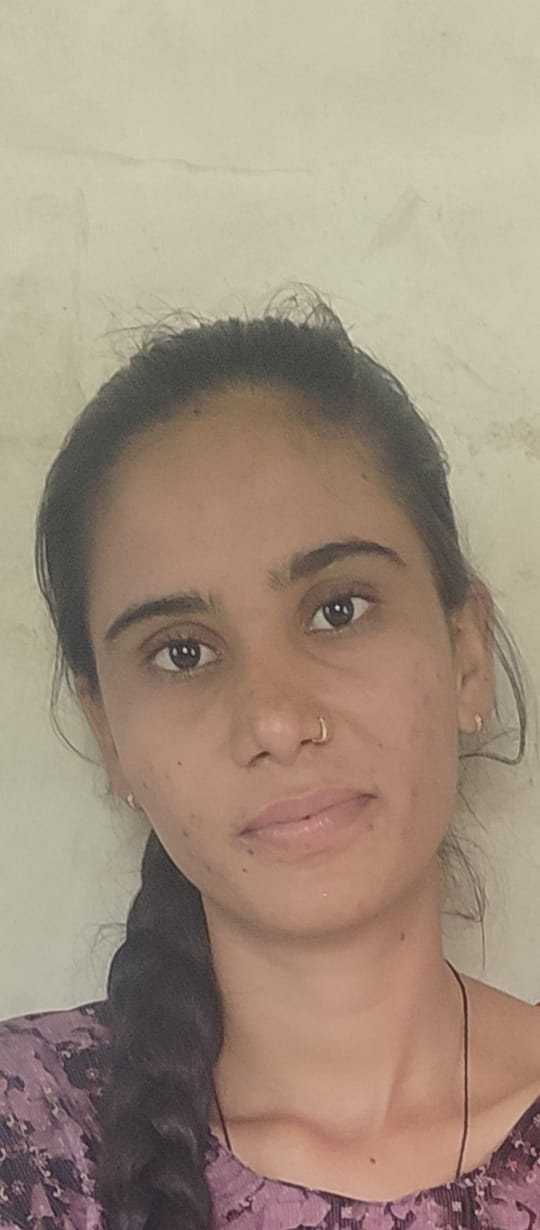


📋 DIAGNOSIS: FRECKLE

💊 RECOMMENDED MARKET PRODUCTS:

1️⃣  STEP 1: CLEANSE
   • CeraVe Foaming Cleanser ($$)

2️⃣  STEP 2: TREAT (Active Serums)
   • Minimalist 10% Niacinamide ($)

3️⃣  STEP 3: MOISTURIZE
   • CeraVe Moisturizing Cream ($$)

📅 SUGGESTED INTRODUCTION SCHEDULE
⚠️  SAFETY FIRST: Do NOT start everything at once.

Week 1: Start the MOISTURIZER only.
   (Test if your skin likes the basic hydration)

Week 2: Add the CLEANSER.
   (Now use Cleanser + Moisturizer)

Week 3: Add Minimalist 10% Niacinamide ($) (Slowly!)
   (Use only 2 times a week at first, then every other day)
--------------------------------------------------


In [64]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    generate_prescription(filename)